In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import math
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# xls = pd.ExcelFile(r'/data/MGP/TestPoints_20220203_ResFeasible.xlsx')
# df=pd.read_excel(xls,'ResFeasible',header=1).dropna(how='all', axis=1)
# df.drop('#',axis=1,inplace=True)
#pd.to_pickle('../../DataL_Full.pkl')                  
df=pd.read_pickle('DataL2_Full.pkl')

In [3]:
print(df.shape)
df.head()

(63116, 36)


,Liquid density [kg/m3],Liquid \nviscosity\n [Pa.s],Gas molar mass \n[g/mol],Gas inlet compressibility\n,Hub radius [m],Tip radius [m],Stage 1 [y=1/n=0],Tin [K],Pin [kPa],GVFin,...,Power [kW],Hp [kJ/kg],Axial Power losses [kW],Side wall windage loss [kW],Rotor-diffuser windage [kW],total mechanincal loss [kW],Surge Distance,Total Consumed power,Differential Pressure [kPa],Original Order
0,989.321765,0.000558,16.042999,0.974302,0.14,0.16,1,322.017877,1867.320507,44.657495,...,181.948011,1.546615,35.354530,9.874548,8.865901,106.246540,3.706551,288.194551,720.180947,1
1,997.303292,0.000839,16.042999,0.960245,0.14,0.16,1,300.789449,2261.871734,22.560723,...,30.309235,0.342669,17.295614,1.715483,1.760581,31.339485,6.251218,61.648720,215.473689,2
2,992.909998,0.000611,16.042999,0.930369,0.14,0.16,1,316.852547,5056.459294,45.132048,...,43.115798,0.486147,22.269798,2.546709,2.444449,42.149602,24.190271,85.265400,212.282906,4
3,979.249421,0.000400,16.042999,0.953943,0.14,0.16,1,344.056608,4641.124807,48.896181,...,52.223397,0.446883,29.328158,5.142692,4.538543,66.518872,58.504924,118.742269,177.964122,5
4,991.458984,0.000593,16.042999,0.954341,0.14,0.16,1,318.474477,3259.999596,39.688098,...,191.361153,1.508498,34.631867,10.224433,9.264067,108.307609,2.866052,299.668761,748.119063,7


In [4]:
data=df[['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Differential Pressure [kPa]', 'Qin [m3/s]', 'Pout [kPA]', 'GVFin', 'Hp [kJ/kg]', 'GVFout','Qv_out [m3/s]','Surge Distance', 'phi']]

In [5]:
phi_surge=0.076
data['Surge Distance Eq'] = 100*(data['phi']-phi_surge)/phi_surge 

In [6]:
# since this xgb version does not recognise column names with square brackets, commas,\ they need to be replaced with _ 
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
# since this xgb version does not recognise column names with square brackets, commas need to replace the column names.
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [7]:
INPUT_C=['Tin _K_','Pin _kPa_','N _rpm_','Total Consumed power','Differential Pressure _kPa_'] #
#OUTPUT_C =['GVFin','Qin _m3/s_','GVFout','Qv_out _m3/s_','Surge Distance Eq'] #,'Phi_Surge','Hp _kJ/kg_','phi']
OUTPUT_C =['Surge Distance Eq']
X_1=data[INPUT_C]
y_1=data[OUTPUT_C]

In [8]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split

train_X1, test_X1, train_y1, test_y1 = train_test_split(X_1, y_1, train_size=0.8, random_state=32)

In [9]:
train_X1.shape, test_X1.shape, train_y1.shape, test_y1.shape

((50492, 5), (12624, 5), (50492, 1), (12624, 1))

In [10]:
train_y=train_y1.copy() 
test_y=test_y1.copy() 

In [11]:
import time
start_time = time.time()
print(time.asctime( time.localtime(time.time()) ))

# Try a simple XGB model
#other_params={'learning_rate':0.1,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}

# Best params from opt SD alone
other_params={'learning_rate':0.1,'n_estimators':700,'max_depth':8,'min_child_weight':8,'subsample':0.6,'colsample_bytree':1.0,'gpu_id': 0,'tree_method': 'gpu_hist'}

#xgb_regressor=xgb.XGBRegressor(objective='reg:squarederror',**other_params).fit(X,y)
#prediction_all=xgb_regressor.predict(X)
multioutputregressor_1=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X1, train_y)
#GPU attempt, doesn't work
#multioutputregressor_1=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',device='gpu',**other_params)).fit(train_X1, train_y)
print("--- %s seconds ---" % (time.time() - start_time))

Tue Apr 12 13:30:21 2022
--- 8.925742626190186 seconds ---


In [12]:
A = multioutputregressor_1.predict(data[INPUT_C])
for i, out in enumerate(OUTPUT_C):
    data[out+'_pred'] = A[:,i]

In [13]:
for i, out in enumerate(OUTPUT_C):
    data[out+'_residuals'] = data[out] - data[out+'_pred']

In [14]:
data_test = data.iloc[test_y.index]

In [21]:
#test_y_pred = data_test[OUTPUT_C] 
#test_y_pred = data_test[['GVFin_pred','Qin _m3/s__pred','GVFout_pred','Qv_out _m3/s__pred','Surge Distance Eq_pred']]
test_y_pred = data_test[['Surge Distance Eq_pred']]

In [22]:
test_y_pred

,Surge Distance Eq_pred
19573,18.294149
11959,25.766733
62949,11.725581
31121,71.808052
18293,-3.263426
...,...
21588,0.266907
50670,28.295582
40154,18.641672
48920,51.201088


In [23]:
predictions_1=multioutputregressor_1.predict(test_X1)

# Get the performance of predictions on all output parameters
print('Root_mean_squared_error_test set_',math.sqrt(mean_squared_error(test_y,test_y_pred)))
print('R2 Score_test set_xgb',r2_score(test_y,test_y_pred))

Root_mean_squared_error_test set_ 4.794202378675843
R2 Score_test set_xgb 0.9543179595345781


In [24]:
# # Get the performance of predictions_1 on all output parameters
# for i, out in enumerate(OUTPUT_C):    
#     print(f'Root_mean_squared_error_test set_{out}', math.sqrt(mean_squared_error(test_y[out],test_y_pred[out+'_pred'])))
#     print(f'R2 Score_test set_xgb_{out}', r2_score(test_y[out],test_y_pred[out+'_pred']))
#     print('________________________________\n')

In [25]:
# Nice table for metrics
dfppt=pd.DataFrame(columns=['Variable','RMSE','R²'])
A=[];B=[];C=[]
for i, out in enumerate(OUTPUT_C):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_y[out],test_y_pred[out+'_pred'])),4))
    C.append(round(r2_score(test_y[out],test_y_pred[out+'_pred']),4)) 
dfppt['Variable']=A
dfppt['RMSE']=B
dfppt['R²']=C
dfppt

,Variable,RMSE,R²
0,Surge Distance Eq,4.7942,0.9543


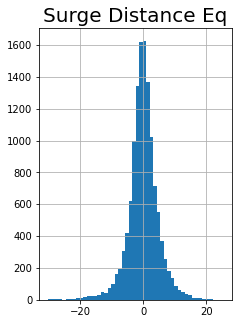

In [26]:
plt.figure(figsize=(20,5)) 
for ii,output in enumerate(OUTPUT_C):

    residual = data_test[output+'_residuals'] #pred - y
   
    plt.subplot(1,5,ii+1)

    plt.hist(residual,bins=50)
    plt.title(output+'_residuals', fontsize=20)
#     plt.ylabel(output, fontsize=20)
#     plt.xlabel('# of Input', fontsize=20)
    plt.grid(True)
    
    #plt.show() 

In [28]:
data_test[['Surge Distance Eq_residuals']].describe()

,Surge Distance Eq_residuals
count,12624.000000
mean,-0.023358
std,4.794335
min,-30.068885
25%,-2.357607
50%,-0.008478
75%,2.435511
max,25.309088


In [29]:
# Get mean as standard deviation
mean = data_test['Surge Distance Eq_residuals'].mean()
std = data_test['Surge Distance Eq_residuals'].std()

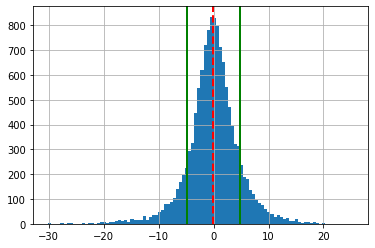

In [30]:
data_test['Surge Distance Eq_residuals'].hist(bins=100)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(std, color='g', linewidth=2)
plt.axvline(-std, color='g', linewidth=2)

In [31]:
std

4.794335370664859

In [32]:
out='Surge Distance Eq'
data_test['ErrSDpc']=abs(data_test[out]-data_test[out+'_pred'])/data_test[out]*100

In [33]:
ds=data_test['ErrSDpc'][data_test['ErrSDpc']<4]
fracOK=len(ds)/len(data_test)
fracOK

0.4124683143219265

(-10.0, 100.0)

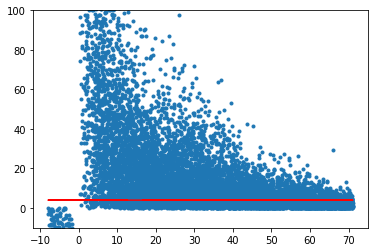

In [35]:
out='Surge Distance Eq'
plt.plot(data_test[out],data_test['ErrSDpc'],'.')
plt.plot(data_test[out],4*np.ones(len(data_test[out])),'r')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
plt.ylim(-10,100)

<AxesSubplot:>

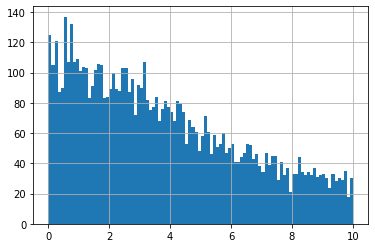

In [37]:
data_test['ErrSDpc'].hist(bins=100,range=[0,10])

# Other Stuff

In [ ]:
import matplotlib.pyplot as plt

n_points=20
#output = 'Phi_Surge'
output = 'Surge Distance Eq'
#x, pred, y = range(len(predictions_1))[:n_points], test_y1[output][:n_points], predictions_1[:,4][:n_points]
x, pred, y = range(len(test_y))[:n_points], test_y[output][:n_points], test_y_pred[output+'_pred'][:n_points]

ci = 1.96 * np.std(y)/np.sqrt(len(x))

plt.figure(figsize=(20,12))
plt.plot(x, y, color='b', marker='o', label='test')
plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.25, label='ci')
plt.title('95%% Confidential interval for %s' %output, fontsize=20)
plt.ylabel(output, fontsize=12)
plt.xlabel('# of Input', fontsize=12)
plt.legend()
plt.show()

In [ ]:
for ii,output in enumerate(OUTPUT_C):

#     x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
    x, pred, y = range(len(test_y))[:n_points], test_y[output][:n_points], test_y_pred[output+'_pred'][:n_points]
    residual = pred - y

    plt.figure(figsize=(20,12))    
    plt.subplot(221)

    plt.plot(x, y, color='b', marker='o', label='test')
    plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
    plt.title(output, fontsize=20)
    plt.ylabel(output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)

    
    plt.subplot(222)
    plt.plot(x, residual, color='b', marker='o', label='test')
    plt.title('Residuals '+output, fontsize=20)
    plt.ylabel('Residuals '+output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    
    plt.show()    

In [ ]:
for ii,output in enumerate(OUTPUT_C):

#     x, pred, y = range(len(predictions_1))[:], test_y[output][:], predictions_1[:,ii][:]
    x, pred, y = range(len(test_y)), test_y[output], test_y_pred[output+'_pred']
    residual = pred - y

    plt.figure(figsize=(20,12))    
    plt.subplot(221)

    plt.plot(y, pred, '.') #color='b', marker='o', label='test')
    plt.title(output, fontsize=20)
    plt.ylabel('predicted y', fontsize=20)
    plt.xlabel('y', fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True)

    
    plt.subplot(222)
    plt.plot(x, residual, '.') #color='b', marker='o', label='test')
    plt.title('Residuals '+output, fontsize=20)
    plt.ylabel('Residuals '+output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True)
    
    plt.show() 